## Training with a Larger Dataset - Cats and Dogs

In the previous lab you trained a classifier with a horses-v-humans dataset. You saw that despite getting great training results, when you tried to do classification with real images, there were many errors, due primarily to overfitting -- where the network  does very well with data that it has previously seen, but poorly with data it hasn't!

In this lab you'll look at a real, and very large dataset, and see the impact this has to avoid overfitting.

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [3]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download
# https://www.microsoft.com/en-us/download/details.aspx?id=54765
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2024-11-21 00:45:55--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.252.210, 2600:1417:3f:688::317f, 2600:1417:3f:69c::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.252.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   155MB/s    in 5.6s    

2024-11-21 00:46:01 (141 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [11]:
# Note that this may take some time.
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/90 ━━━━━━━━━━━━━━━━━━━━ 22s 589ms/step - acc: 0.5340 - loss: 0.8033

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 575ms/step - acc: 0.5563 - loss: 0.7604 - val_acc: 0.6873 - val_loss: 0.5914
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7027 - val_loss: 0.5905
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 471ms/step - acc: 0.6711 - loss: 0.6084 - val_acc: 0.7227 - val_loss: 0.5926
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7037 - val_loss: 0.5961
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 471ms/step - acc: 0.7167 - loss: 0.5520 - val_acc: 0.7513 - val_loss: 0.5145
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7477 - val_loss: 0.5141
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 479ms/step - acc: 0.7557 - loss: 0.5017 - val_acc: 0.7707 - val_loss: 0.4815
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7898 - val_loss: 0.4677
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 470ms/step - acc: 0.7692 - loss: 0.4786 - val_acc: 0.7800 - val_loss: 0.4487
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

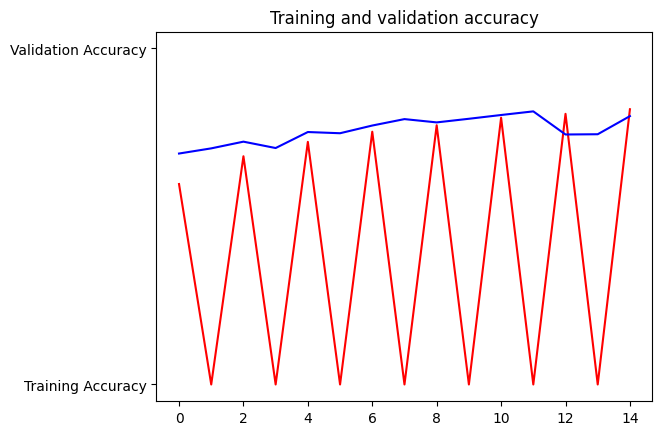

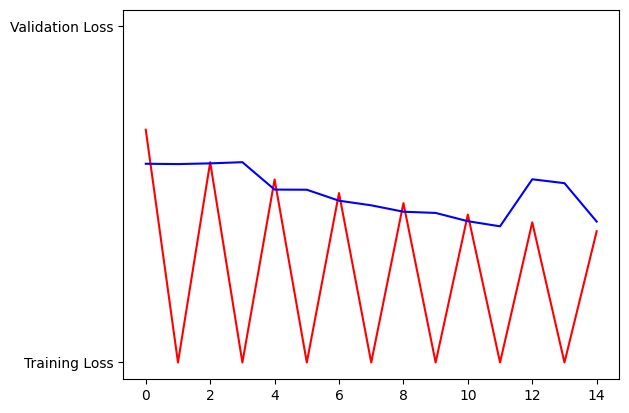

<Figure size 640x480 with 0 Axes>

In [12]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [13]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving balineser-kat.jpg to balineser-kat.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
[0.00464351]
balineser-kat.jpg is a cat
